Reliability Models for Facility Location:The Expected Failure Cost Case
---

Base on the following article:

*Snyder, L. V., & Daskin, M. S. (2005). Reliability models for facility location: the expected failure cost case. Transportation Science, 39(3), 400-416.*

In [325]:
# Colecting the problem
from PythonLib.dataset.mongodb import MongoClient
# Solving the problem
from PythonLib.solvers.uflp import uflp
# Representing the network
from PythonLib.dataviz.network import Network

from sklearn.neighbors import DistanceMetric
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Selecting the problem

First, we collect the dataset from our database using **MonClient**.

In [326]:
dataset = MongoClient(db = {
# MongoClient let us connect to the database and manipulate our dataset
    "mongo_host": "ns396089.ip-37-59-38.eu",
    "mongo_port": 32771,
    "mongo_db_name": "NETWORK-AND-DISCRETE-LOCATION"
}, q = {
    'metadata.author': 'Mark S. Daskin',
    'metadata.topic': 'NETWORK-AND-DISCRETE-LOCATION',
    'metadata.dataset': '49-nodes'
},f=None)

We can display the dataset using the method **get** which return a pandas Dataframe containing our data

In [329]:
df = dataset.get(index="ID")
df.index = df.index - 1
df.head()

,LATITUDE,LONGITUDE,STATE POP,CITY POP,FIXED COST,CITY
ID,,,,,,
0,-121.467360,38.566850,29760021,369365,115800,< Sacramento CA >
1,-73.799017,42.665750,17990455,101082,101800,< Albany NY >
10,-84.422592,33.762900,6478216,394017,71200,< Atlanta GA >
11,-77.474584,37.531050,6187358,203056,66600,< Richmond VA >
12,-71.017892,42.336029,6016425,574283,161400,< Boston MA >


## Solving the UFLP problem

The uncapacitated facility location problem takes as inputs two sets of **Customers** and **Facilities**, as well as the list **f** containing the fixed cost of each facility and the matrix **c** representing the cost of serving a customer given a facility.

In [334]:
# Set of customer
Customers = df.index.tolist()
Facilities = [0,4,5,21,2]
fixed_cost = df["FIXED COST"]
# Distance matrix in Km frm long/lat
distances = DistanceMetric.get_metric('haversine').pairwise(df[["LATITUDE","LONGITUDE"]].apply(np.radians)) * 3959
# The transportation cost are taken to be $0.00001 per mile per unit of demande
# The demande is proportinal to the state population
transportation_cost = np.round(0.00001 * distances * df["STATE POP"][None, :].T)

In [337]:
pd.DataFrame(transportation_cost)

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.0,979632.0,761420.0,904612.0,1036854.0,726309.0,602034.0,659634.0,713140.0,97265.0,...,944878.0,429007.0,914067.0,1004251.0,343450.0,654383.0,791244.0,758812.0,960285.0,880089.0
1,592205.0,0.0,133318.0,48313.0,34594.0,153567.0,228562.0,193780.0,161744.0,609879.0,...,24268.0,335028.0,41670.0,16303.0,385242.0,196982.0,114386.0,133695.0,14544.0,63613.0
2,165747.0,48007.0,0.0,31198.0,60393.0,8016.0,34746.0,22265.0,10604.0,171626.0,...,40040.0,72736.0,33328.0,53653.0,91029.0,23385.0,7105.0,3887.0,43481.0,25832.0
3,188076.0,16616.0,29797.0,0.0,28139.0,37092.0,62914.0,50944.0,39809.0,193624.0,...,8523.0,99255.0,2350.0,22209.0,116733.0,52032.0,23631.0,30433.0,11909.0,5283.0
4,209615.0,11569.0,56088.0,27362.0,0.0,62911.0,88001.0,76367.0,65639.0,215478.0,...,19081.0,123586.0,25233.0,6929.0,140400.0,77437.0,49798.0,56273.0,15785.0,32496.0
5,135308.0,47325.0,6860.0,33236.0,57973.0,0.0,23154.0,12422.0,2589.0,140668.0,...,40719.0,55930.0,34978.0,52059.0,71428.0,13402.0,12101.0,6165.0,43604.0,28736.0
6,103517.0,65011.0,27446.0,52031.0,74846.0,21370.0,0.0,9905.0,19109.0,108650.0,...,58952.0,30426.0,53653.0,69333.0,44567.0,9001.0,32538.0,26986.0,61612.0,47838.0
7,108427.0,52691.0,16813.0,40277.0,62091.0,10960.0,9469.0,0.0,8816.0,113249.0,...,46887.0,38461.0,41822.0,56839.0,52069.0,874.0,21636.0,16338.0,49431.0,36282.0
8,116872.0,43849.0,7983.0,31380.0,53210.0,2278.0,18213.0,8790.0,0.0,121509.0,...,37990.0,46977.0,32937.0,48029.0,60652.0,9640.0,12842.0,7688.0,40544.0,27385.0
9,15906.0,164982.0,128932.0,152296.0,174301.0,123479.0,103333.0,112669.0,121247.0,0.0,...,158979.0,74407.0,153946.0,169173.0,61324.0,111800.0,134045.0,128882.0,161587.0,148187.0


In [338]:
m, X, Y = uflp(Customers, Facilities, fixed_cost, transportation_cost, name='UFLP')

In [339]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Linux 64bit
* Python is present, version is 3.6.5
* docplex is present, version is (2, 4, 61)
* CPLEX wrapper is present, version is 12.8.0.0, located at: /opt/conda/lib/python3.6/site-packages


In [340]:
m.print_information()

Model: UFLP
 - number of variables: 250
   - binary=250, integer=0, continuous=0
 - number of constraints: 294
   - linear=294
 - parameters: defaults


In [341]:
solution = m.solve()

In [342]:
solution.solve_details.time

0.009616851806640625

In [343]:
m.export_as_lp("uflp_formulation")

'uflp_formulation.lp'

In [344]:
solution.export("uflp_solution.json")

In [345]:
solution.kpi_value_by_name("transportation cost")

738722.0

In [346]:
solution.kpi_value_by_name("fixed cost")

213400

## Analyse the probleme and the solution

We use the **dataviz** package to convert our dataset into a **Network** object so that we can plot it.

In [347]:
network = Network(dataset)

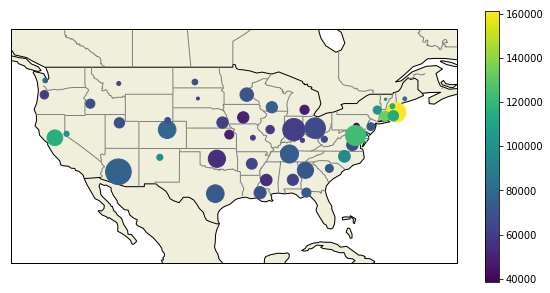

In [348]:
network.plot_nodes(node_size=("CITY POP",1/1500), node_color="FIXED COST")

In [349]:
network.G.add_edges_from([key for key in X if X[key].solution_value == 1])

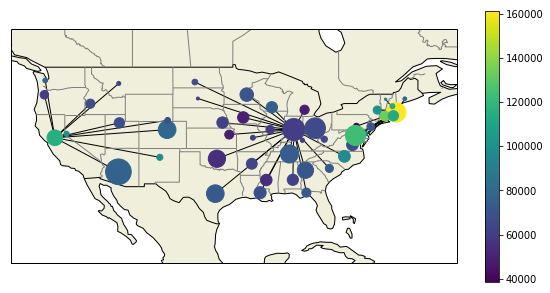

In [350]:
network.plot_nodes(node_size=("CITY POP",1/1500), node_color="FIXED COST")

In [351]:
facility_solution = df.loc[[key for key in Y if Y[key].solution_value == 1]]
facility_solution

,LATITUDE,LONGITUDE,STATE POP,CITY POP,FIXED COST,CITY
ID,,,,,,
0,-121.467360,38.566850,29760021,369365,115800,< Sacramento CA >
4,-76.884503,40.276050,11881643,52376,38400,< Harrisburg PA >
5,-89.644654,39.781433,11430602,105227,59200,< Springfield IL >


In [352]:
demand_served = pd.DataFrame([[j,df.iloc[i]["STATE POP"]] for i,j in X if X[i,j].solution_value == 1],columns=["j","demande"]) \
                    .set_index("j") \
                    .groupby(level=0).sum() \
                    .apply(lambda x: 100 * x / float(x.sum())).round()

In [353]:
facility_solution["demand_served"] = demand_served["demande"]
facility_solution

,LATITUDE,LONGITUDE,STATE POP,CITY POP,FIXED COST,CITY,demand_served
ID,,,,,,,
0,-121.467360,38.566850,29760021,369365,115800,< Sacramento CA >,21.0
4,-76.884503,40.276050,11881643,52376,38400,< Harrisburg PA >,26.0
5,-89.644654,39.781433,11430602,105227,59200,< Springfield IL >,54.0
